<table width="100%">
  <tr>
    <td width="50%" align="left">
      <img src="imgs/Brockmann_Consult_Logo_Horizontal_Tagline_1.1.png" alt="Company Logo" style="max-width: 100%; height: auto;" width="300">
    </td>
    <td width="50%" align="right">
      <img src="imgs/logo-light.png" alt="xcube logo" style="max-width: 100%; height: auto;" width="150">
    </td>
  </tr>
</table>

<table width="100%">
  <tr>
    <td width="100%" align="center">
      <h1 style="text-align: center; margin-bottom: 0.3em; font-weight: bold;">
        Access Dataset from Copernicus Marine Environment Monitoring Service (CMEMS)
      </h1>
      <div style="height: 0.5em;"></div>
      <h2 style="text-align: center; margin-top: 0; font-weight: bold;">
        Using xcube-cmems
      </h2>
    </td>
  </tr>
</table>


**Author(s):** Clara Backens, Konstantin Ntokas, Pontus Lurcock  
**Affiliation:** Brockmann Consult GmbH  
**GitHub:** [xcube-cmems](https://github.com/xcube-dev/xcube-cmems)  
**Documentation:** [xcube-cmems](https://github.com/xcube-dev/xcube-cmems/blob/main/README.md)


---

## Introduction

This notebook demonstrates how to discover and access CMEMS datasets programmatically using the xcube-cmems plugin. The plugin provides a unified interface to browse CMEMS collections, open datasets, and work with them as xarray objects.

<div style="border: 2.5px solid #999; padding: 1em; border-radius: 6px; background-color: #eaeaea;">
  <strong>Objectives:</strong>
  <ul>
    <li>Understand how <code>xcube-cmems</code> connects to and retrieves data from CMEMS.</li>
    <li>Explore the data access of with ocean-colour datasets from single-sensor and multi-sensor CMEMS products.</li>
  </ul>
</div>

> **Disclaimer**  
> This notebook demonstrates the use of open source software and is intended for educational and illustrative purposes only. All software used is subject to its respective licenses. The authors and contributors of this notebook make no guarantees about the accuracy, reliability, or suitability of the content or included code. Use at your own discretion and risk. No warranties are provided, either express or implied.


---

## Install the xcube-cmems Data Store

The xcube-cmems package is implemented as a **xcube plugin** and can be installed using `conda/mamba` from the conda-forge channel.

- 🐍 **Conda (conda-forge):** [xcube-cmems on Anaconda](https://anaconda.org/conda-forge/xcube-cmems) `conda install -c conda-forge xcube-cmems`

  You can also use **Mamba** as a faster alternative to Conda: `mamba install -c conda-forge xcube-cmems`

---

In [1]:
from xcube.core.store import new_data_store

First, we initiate a data store which is used to store the final datacubes. In this case we write it to a local file system. 

> Note!
> For the Viewer demonstration we wrote the dataset to a S3 AWS object storage.

In [2]:
store_storage = new_data_store("file", root="storage")

Next, we initiate a cmems data store.

In [3]:
store =  new_data_store("cmems")

First, since we want to access multiple CMEMS products, we will define a common bounding box and time range:

In [4]:
time_range = ("2023-06-01", "2023-06-30")
bbox = [4.3, 58.0, 6.5, 59.6]

Next, we want to access HR-OC dataset for the North West Shelf Region daily observations mosaic based on Sentinel-2 Level-1C.

> Note:  
> The data IDs can be view on the [CMEMS webpage for each product](https://data.marine.copernicus.eu/product/OCEANCOLOUR_NWS_BGC_HR_L3_NRT_009_203/services).

In [5]:
%%time
ds = store.open_data(
    'cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l3-hr-mosaic_P1D-m',
    time_range=time_range,
    bbox=bbox,
)

del ds.CHL.attrs["valid_min"]
del ds.SPM.attrs["valid_min"]
del ds.TUR.attrs["valid_min"]

ds = ds.chunk(dict(time=1, latitude=-1, longitude=-1))
ds

INFO - 2025-12-10T21:49:38Z - Selected dataset version: "202107"
INFO - 2025-12-10T21:49:38Z - Selected dataset part: "default"


CPU times: user 251 ms, sys: 123 ms, total: 374 ms
Wall time: 1.72 s


<xarray.Dataset> Size: 784MB
Dimensions:    (time: 30, latitude: 1728, longitude: 1260)
Coordinates:
  * time       (time) datetime64[ns] 240B 2023-06-01 2023-06-02 ... 2023-06-30
  * latitude   (latitude) float64 14kB 58.0 58.0 58.0 58.0 ... 59.6 59.6 59.6
  * longitude  (longitude) float64 10kB 4.3 4.302 4.304 ... 6.496 6.498 6.5
Data variables:
    CHL        (time, latitude, longitude) float32 261MB dask.array<chunksize=(1, 1728, 1260), meta=np.ndarray>
    SPM        (time, latitude, longitude) float32 261MB dask.array<chunksize=(1, 1728, 1260), meta=np.ndarray>
    TUR        (time, latitude, longitude) float32 261MB dask.array<chunksize=(1, 1728, 1260), meta=np.ndarray>
Attributes:
    contact:      https://marine.copernicus.eu/
    history:      Calvalus 2.21 mosaic generation; Acolite 20210203; C2RCC 8....
    source:       Sentinel-2 MSI L1C
    institution:  Brockmann Consult GmbH, RBINS, VITO for CMEMS, Mercator Ocean
    Conventions:  CF-1.7
    references:   https://marine.copernicus.eu/
    title:        CMEMS HR-OC North West Shelf Region transparency (spm, tur)...

We can plot one timestamp as an example.

CPU times: user 1.29 s, sys: 259 ms, total: 1.55 s
Wall time: 3.1 s


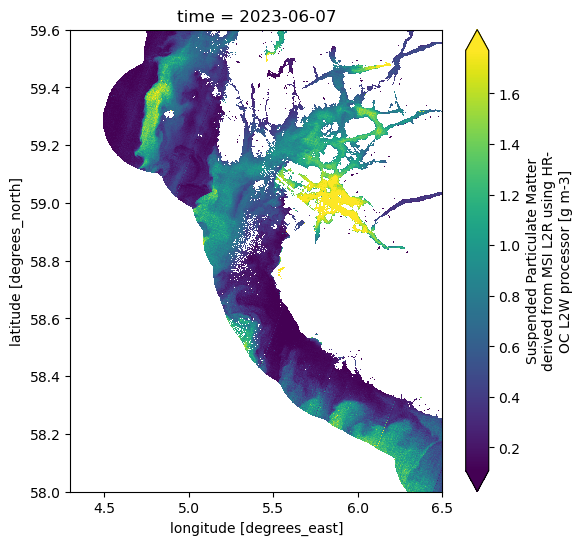

In [6]:
%%time
ds.SPM.isel(time=6).plot(robust=True, figsize=(6, 6))

We then can write the data cube to our storage.

In [7]:
%%time
store_storage.write_data(ds, 'oc_nws_cmems.zarr', replace=True)

CPU times: user 4.07 s, sys: 700 ms, total: 4.77 s
Wall time: 9.21 s


'oc_nws_cmems.zarr'

---

Next we want to access a gap filled product from various sources with 4km resolution, see the [CMEMS catalog](https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L4_MY_009_104/description) for more details on the dataset.

In [17]:
%%time
ds = store.open_data(
    "cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D",
    time_range=time_range,
    bbox=bbox,
)

ds = ds.chunk(dict(time=1, latitude=-1, longitude=-1))
ds

INFO - 2025-12-09T16:48:55Z - Selected dataset version: "202311"
INFO - 2025-12-09T16:48:55Z - Selected dataset part: "default"


CPU times: user 319 ms, sys: 61.3 ms, total: 380 ms
Wall time: 1.49 s


<xarray.Dataset> Size: 786kB
Dimensions:          (time: 30, latitude: 38, longitude: 53)
Coordinates:
  * time             (time) datetime64[ns] 240B 2023-06-01 ... 2023-06-30
  * latitude         (latitude) float32 152B 58.02 58.06 58.1 ... 59.52 59.56
  * longitude        (longitude) float32 212B 4.313 4.354 4.396 ... 6.438 6.479
Data variables:
    CHL              (time, latitude, longitude) float32 242kB dask.array<chunksize=(1, 38, 53), meta=np.ndarray>
    CHL_uncertainty  (time, latitude, longitude) float64 483kB dask.array<chunksize=(1, 38, 53), meta=np.ndarray>
    flags            (time, latitude, longitude) int8 60kB dask.array<chunksize=(1, 38, 53), meta=np.ndarray>
Attributes:
    history:      Created using software developed at ACRI-ST
    Conventions:  CF-1.8, ACDD-1.3
    institution:  ACRI
    title:        cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D
    comment:      average
    references:   http://www.globcolour.info GlobColour has been originally f...
    source:       surface observation
    contact:      servicedesk.cmems@acri-st.fr

Also there we can plot the same time slice as above:

CPU times: user 85.1 ms, sys: 18 ms, total: 103 ms
Wall time: 1.07 s


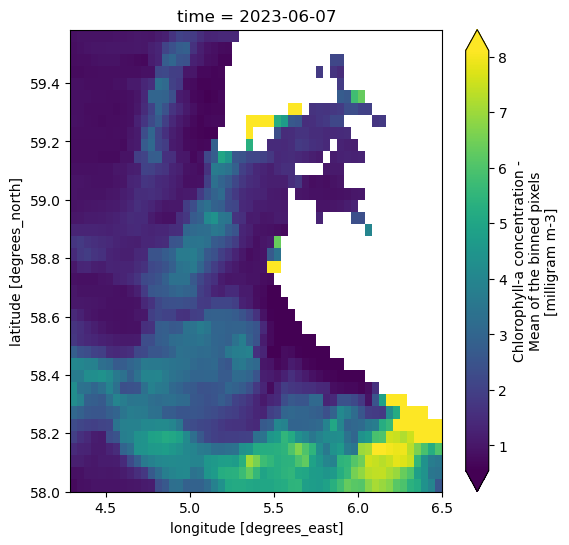

In [18]:
%%time
ds.CHL.isel(time=6).plot(robust=True, figsize=(6, 6))

And we can write the dataset to the storage:

In [19]:
%%time
store_storage.write_data(ds, "oc_glo_cmems_4km.zarr", replace=True)

CPU times: user 3.96 s, sys: 705 ms, total: 4.66 s
Wall time: 9.41 s


'oc_glo_cmems_4km.zarr'

---

Lastly, we want to access the plankton dataset derived from the OLCI instrument, see the [CMEMS catalog](https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L3_MY_009_103/description) for more details on the dataset.

In [20]:
%%time
ds = store.open_data(
    'cmems_obs-oc_glo_bgc-plankton_my_l3-olci-300m_P1D',
    time_range=time_range,
    bbox=bbox,
)

ds = ds.chunk(dict(time=1, latitude=-1, longitude=-1))
ds

INFO - 2025-12-09T16:49:51Z - Selected dataset version: "202211"
INFO - 2025-12-09T16:49:51Z - Selected dataset part: "default"


CPU times: user 224 ms, sys: 83.7 ms, total: 308 ms
Wall time: 1.57 s


<xarray.Dataset> Size: 44MB
Dimensions:          (time: 30, latitude: 288, longitude: 396)
Coordinates:
  * time             (time) datetime64[ns] 240B 2023-06-01 ... 2023-06-30
  * latitude         (latitude) float32 1kB 58.0 58.01 58.01 ... 59.59 59.6
  * longitude        (longitude) float32 2kB 4.303 4.308 4.314 ... 6.492 6.497
Data variables:
    CHL              (time, latitude, longitude) float32 14MB dask.array<chunksize=(1, 288, 396), meta=np.ndarray>
    CHL_uncertainty  (time, latitude, longitude) float64 27MB dask.array<chunksize=(1, 288, 396), meta=np.ndarray>
    flags            (time, latitude, longitude) int8 3MB dask.array<chunksize=(1, 288, 396), meta=np.ndarray>
Attributes:
    history:      Created using software developed at ACRI-ST
    Conventions:  CF-1.8, ACDD-1.3
    institution:  ACRI
    title:        cmems_obs-oc_glo_bgc-plankton_my_l3-olci-300m_P1D
    comment:      average
    references:   http://www.globcolour.info GlobColour has been originally f...
    source:       surface observation
    contact:      servicedesk.cmems@acri-st.fr

Also there we can plot the same time slice as above:

CPU times: user 744 ms, sys: 90.9 ms, total: 835 ms
Wall time: 2.65 s


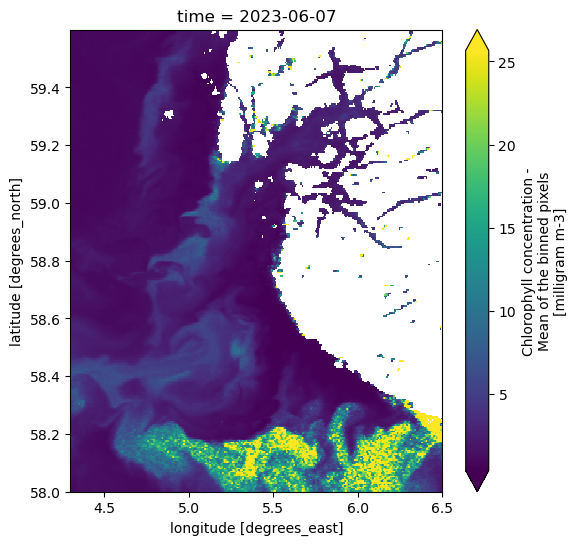

In [21]:
%%time
ds.CHL.isel(time=6).plot(robust=True, figsize=(6, 6))

And we can write the dataset to the storage:

In [22]:
%%time
store_storage.write_data(ds, "oc_glo_cmems_300m.zarr", replace=True)

CPU times: user 1.69 s, sys: 685 ms, total: 2.37 s
Wall time: 5.22 s


'oc_glo_cmems_300m.zarr'

---

<table width="100%">
  <tr>
    </td>
    <td width="20%"></td>
    <td width="60%" align="center" style="font-size: 0.9em; color: #666; vertical-align: middle;">
      &copy; 2025 Brockmann Consult GmbH &nbsp;|&nbsp;
      <a href="https://www.brockmann-consult.de" target="_blank">Website</a>
    <td width="20%" align="right" style="vertical-align: middle;">
      <img src="imgs/Brockmann_Consult_Logo_Horizontal_1.1.png" alt="Company Logo" width="150">
    </td>
  </tr>
</table>